In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# DATA PREPARATION

LOADING THE DATA SET

In [163]:
trades_data = pd.read_csv("historical_data.csv")
emotion_data = pd.read_csv("fear_greed_index.csv")

print(f"Trades DataSet:\nRows: {trades_data.shape[0]}  Columns: {trades_data.shape[1]}")
print(f"Emotion DataSet:\nRows: {emotion_data.shape[0]}  Columns: {emotion_data.shape[1]}")

Trades DataSet:
Rows: 211224  Columns: 16
Emotion DataSet:
Rows: 2644  Columns: 4


DATA INFORMATION

In [164]:
print("The structure of the Trades Dataset:\n")
print(trades_data.info())
print("The structure of the Emotion Dataset:\n")
print(emotion_data.info())

The structure of the Trades Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-n

CHECKING FOR MISSING VALUES

In [165]:
print("\n The missing values in Trades Data:")
print(trades_data.isna().sum())
print("\n The total missing values in Trades Data:")
print(trades_data.isna().sum().sum())
print("\n The missing values in Emotion Data:")
print(emotion_data.isna().sum())
print("\n The total missing values in Emotion Data:")
print(emotion_data.isna().sum().sum())



 The missing values in Trades Data:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

 The total missing values in Trades Data:
0

 The missing values in Emotion Data:
timestamp         0
value             0
classification    0
date              0
dtype: int64

 The total missing values in Emotion Data:
0


CHECKING FOR DUPLICATES

In [166]:
print("\n The Duplicated rows in Trade Data:")
print(trades_data.duplicated().sum())
print("\n The Duplicated rows in Emotion Data:")
print(emotion_data.duplicated().sum())


 The Duplicated rows in Trade Data:
0

 The Duplicated rows in Emotion Data:
0


CONVERTING TIMESTAMPS AND ALIGNING DATE

In [167]:
trades_data["Timestamp IST"] = pd.to_datetime(trades_data["Timestamp IST"],dayfirst=True)
emotion_data["date"] = pd.to_datetime(emotion_data["date"])

In [168]:
trades_data["date"] = trades_data["Timestamp IST"].dt.date
emotion_data["date"] = emotion_data["date"].dt.date

In [169]:
merged_data = trades_data.merge(emotion_data, on = "date", how = "left")
print(f"Merged DataSet:\nRows: {merged_data.shape[0]}  Columns: {merged_data.shape[1]}")


Merged DataSet:
Rows: 211224  Columns: 20


KEY METRICS

In [170]:
daily_pnl = (merged_data.groupby(["date", "Account","classification"])["Closed PnL"].sum().reset_index(name="daily_pnl"))
daily_pnl.head(10)

,date,Account,classification,daily_pnl
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,Greed,0.000000
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Extreme Greed,0.000000
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,-205.434737
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,-24.632034
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,0.000000
5,2023-12-17,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,304.982785
6,2023-12-18,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,0.000000
7,2023-12-19,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,1000.538612
8,2023-12-20,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,162.732282
9,2023-12-21,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,537.211402


In [171]:
daily_regime = merged_data.groupby(["date","classification"])["Closed PnL"].sum().reset_index()
daily_regime.head(10)

,date,classification,Closed PnL
0,2023-05-01,Greed,0.000000
1,2023-12-05,Extreme Greed,0.000000
2,2023-12-14,Greed,-205.434737
3,2023-12-15,Greed,-24.632034
4,2023-12-16,Greed,0.000000
5,2023-12-17,Greed,304.982785
6,2023-12-18,Greed,0.000000
7,2023-12-19,Greed,1000.538612
8,2023-12-20,Greed,162.732282
9,2023-12-21,Greed,537.211402


In [172]:
merged_data["win"] = np.where(trades_data["Closed PnL"] > 0, 1, 0)
win_rate = (merged_data.groupby("Account")["win"].mean())
print("\nThe win rate per Account:")
print(win_rate.head(10))

win_rate_emotion = (merged_data.groupby("classification")["win"].mean())
print("\nThe win rate per classification:")
print(win_rate_emotion.head(10))



The win rate per Account:
Account
0x083384f897ee0f19899168e3b1bec365f52a9012    0.359612
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd    0.442720
0x271b280974205ca63b716753467d5a371de622ab    0.301917
0x28736f43f1e871e6aa8b1148d38d4994275d72c4    0.438585
0x2c229d22b100a7beb69122eed721cee9b24011dd    0.519914
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891    0.455215
0x39cef799f8b69da1995852eea189df24eb5cae3c    0.327668
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6    0.475904
0x420ab45e0bd8863569a5efbb9c05d91f40624641    0.234987
0x430f09841d65beb3f27765503d0f850b8bce7713    0.484236
Name: win, dtype: float64

The win rate per classification:
classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: win, dtype: float64


In [173]:
avg_trade_size = (trades_data.groupby("Account")["Size USD"].mean().reset_index(name="avg_trade_size_usd"))
avg_trade_size.head(10)

,Account,avg_trade_size_usd
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16159.576734
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1653.226327
2,0x271b280974205ca63b716753467d5a371de622ab,8893.000898
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,507.626933
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3138.894782
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,1729.941104
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,4790.575486
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,3445.471265
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,5189.367128
9,0x430f09841d65beb3f27765503d0f850b8bce7713,2397.824753


In [174]:
trades_per_day = (merged_data.groupby(["date","classification"])["Trade ID"].count().reset_index(name="trades_per_day"))
avg_trades = (trades_per_day.groupby("classification")["trades_per_day"].mean())
avg_trades.head(10)

classification
Extreme Fear     1528.571429
Extreme Greed     350.807018
Fear              679.527473
Greed             260.637306
Neutral           562.477612
Name: trades_per_day, dtype: float64

In [175]:
pnl_volatility = (trades_data.groupby("Account")["Closed PnL"].std().reset_index(name="pnl_volatility"))
pnl_volatility.head(10)

,Account,pnl_volatility
0,0x083384f897ee0f19899168e3b1bec365f52a9012,4692.452329
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,134.073473
2,0x271b280974205ca63b716753467d5a371de622ab,542.182659
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,113.269353
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,255.829091
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,558.778753
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,730.495484
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,1279.855788
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,2228.336140
9,0x430f09841d65beb3f27765503d0f850b8bce7713,1649.497580


In [176]:
print(trades_data["Side"].unique())
#The values are unique

long_short_ratio = (merged_data.groupby(["classification", "Side"])["Trade ID"].count().unstack(fill_value=0)) 
long_short_ratio["long_short_ratio"] = (long_short_ratio.get("BUY", 0) / long_short_ratio.get("SELL", 1))
long_short_ratio = long_short_ratio.reset_index()
long_short_ratio.head()

['BUY' 'SELL']


Side,classification,BUY,SELL,long_short_ratio
0,Extreme Fear,10935,10465,1.044912
1,Extreme Greed,17940,22052,0.813532
2,Fear,30270,31567,0.958913
3,Greed,24576,25727,0.955261
4,Neutral,18969,18717,1.013464


# PERFORMANCE ANALYSIS



1. Does performance (PnL, win rate) differ between Fear vs Greed days?


Average Daily PnL by Emotion:
classification
Extreme Greed    5161.922644
Greed            3318.100730
Neutral          3438.618818
Fear             5328.818161
Extreme Fear     4619.439053
Name: daily_pnl, dtype: float64


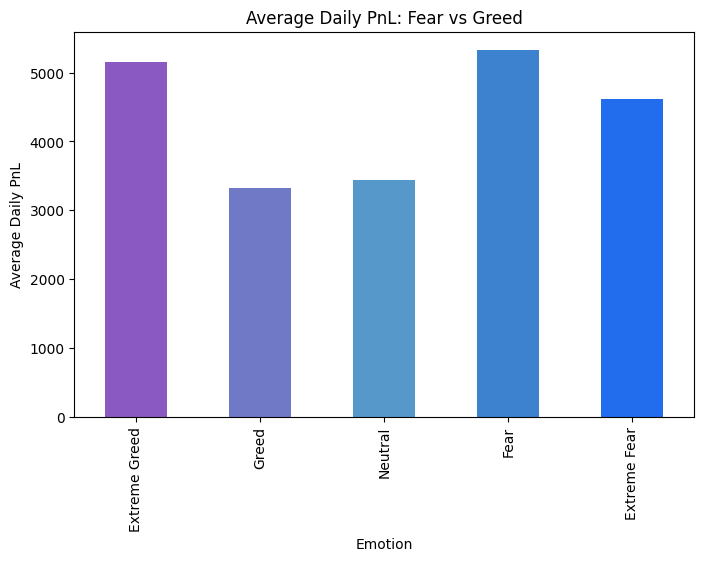

In [177]:
avg_daily_pnl = daily_pnl.groupby("classification")["daily_pnl"].mean()
emotion_order = ["Extreme Greed", "Greed", "Neutral", "Fear", "Extreme Fear"]
ordered_avg_pnl = avg_daily_pnl.reindex(emotion_order)

print("\nAverage Daily PnL by Emotion:")
print(ordered_avg_pnl)

plt.figure(figsize=(8,5))
ordered_avg_pnl.plot(kind="bar", color = ['#8A5AC2', '#7079C6', '#5698CA', '#3C82CE', '#226DED'])
plt.title("Average Daily PnL: Fear vs Greed")
plt.xlabel("Emotion")
plt.ylabel("Average Daily PnL")
plt.show()

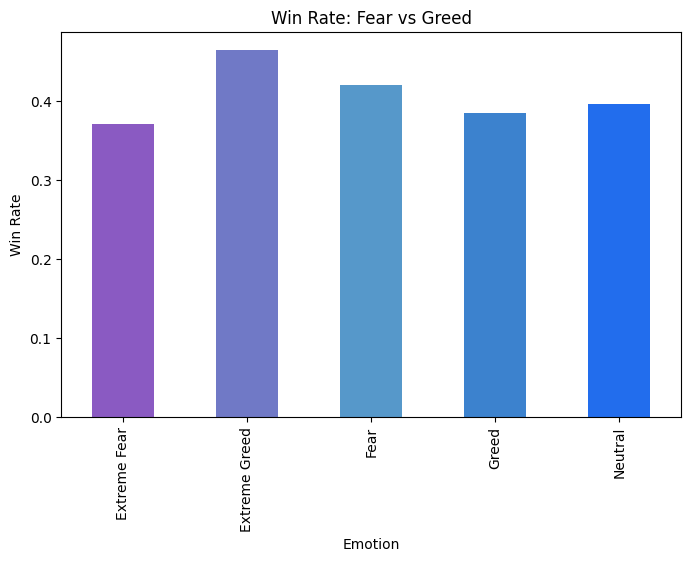

In [178]:
plt.figure(figsize=(8,5))
win_rate_emotion.plot(kind="bar", color = ['#8A5AC2', '#7079C6', '#5698CA', '#3C82CE', '#226DED'])
plt.title("Win Rate: Fear vs Greed")
plt.ylabel("Win Rate")
plt.xlabel("Emotion")
plt.show()

**INTERPRETATIONS:** 

1. Fear -

* Highest average daily PnL.
* Moderate win rate.

Implication - During Fear, traders generate the strongest overall returns despite not having the highest accuracy. This suggests profits are driven by large price swings rather than frequent winning trades. Volatility-capture, breakout, and liquidation-based strategies appear most effective in Fear conditions.

2. Extreme Greed - 

* High average PnL
* Highest win rate

Implication - Strong bullish momentum improves trade predictability. Traders achieve higher accuracy, likely by aligning with prevailing trends. Trend-following and momentum continuation strategies are most effective during Extreme Greed.

3. Greed - 

* Lowest average PnL
* Relatively lower win rate

Implication - Markets in mild optimism appear more stable and efficient, reducing exploitable volatility and edge. Aggressive directional strategies may underperform; tighter risk management is advisable.

4. Extreme Fear — 

* Moderate PnL
* Lowest win rate

Implication - Severe panic increases noise and unpredictability, reducing trade accuracy even though volatility is high. Risk control and position sizing become critical; avoid overexposure during extreme stress.

5. Neutral - 

* Moderate PnL
* Stable win rate

Implication - Balanced market conditions provide steady but unspectacular opportunities. Systematic, market-neutral or mean-reversion approaches may be more appropriate.

SATISTICAL TEST

In [179]:
fear_pnl = daily_pnl[daily_pnl["classification"]=="Fear"]["daily_pnl"]
greed_pnl = daily_pnl[daily_pnl["classification"]=="Greed"]["daily_pnl"]

t_stat, p_value = stats.ttest_ind(fear_pnl, greed_pnl, equal_var=False)

print("\nT-test Results (Daily PnL):")
print("T-stat:", t_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Result: Statistically Significant (The market sentiment Does have a significant impact on Pn)")
else:
    print("Result: Not Statistically Significant (The market sentiment Does Not have a significant impact on PnL)")


T-test Results (Daily PnL):
T-stat: 1.1539988578017333
P-value: 0.24871756720315555
Result: Not Statistically Significant (The market sentiment Does Not have a significant impact on PnL)


**Conclusion:**

The statistical analysis suggests that these patterns are not yet definitive across the entire dataset. But, the observed trends point to a notable "Volatility-Accuracy" trade-off. Historically, Fear regimes have coincided with the highest average profitability—likely driven by large, volatile price swings—whereas Extreme Greed has demonstrated the highest reliability and trade predictability. Interestingly, the transitionary Greed phase appears the least productive, suggesting that the trader's edge may be most pronounced at sentiment extremes. Although these results currently fall below the threshold for statistical significance, they provide a strong qualitative framework: a flexible strategy that shifts from momentum-chasing during high-accuracy "Greed" periods to volatility-capture during high-reward "Fear" periods may offer an advantage, provided strict risk management is maintained to navigate the noise of Extreme Fear.

2. Do traders change behavior based on sentiment (trade frequency, leverage, long/short bias)?

TRADE FRQUENCY - 

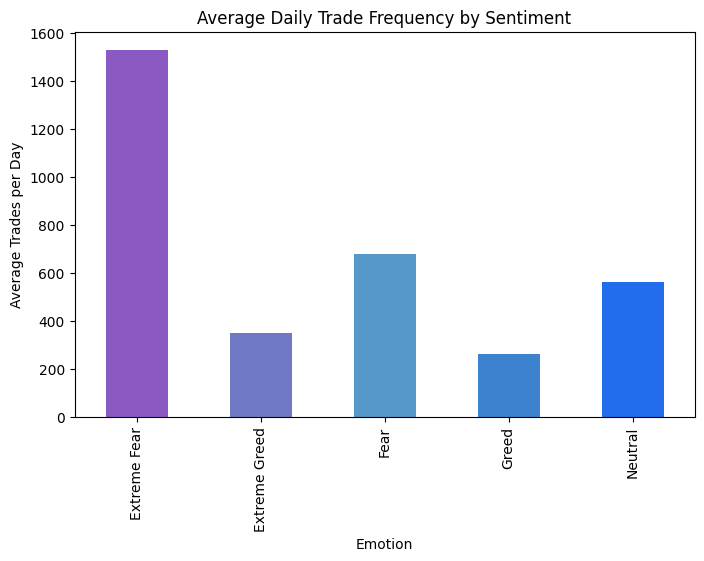

In [180]:
plt.figure(figsize=(8,5))
avg_trades.plot(kind="bar",color = ['#8A5AC2', '#7079C6', '#5698CA', '#3C82CE', '#226DED'])
plt.title("Average Daily Trade Frequency by Sentiment")
plt.ylabel("Average Trades per Day")
plt.xlabel("Emotion")
plt.show()

INTERRETATIONS:

The data reveals a striking surge in activity during periods of market stress, with Extreme Fear triggering an average of over 1,500 trades per day—more than double the frequency of any other sentiment category. This statistically significant spike suggests a "Panic-Induced Hyperactivity" phase, where high volatility likely triggers a cascade of stop-losses or impulsive "revenge trading" as the trader attempts to navigate severe market downturns. In contrast, Greed and Extreme Greed exhibit the lowest trade frequencies, indicating a much more selective and patient execution style when the market is trending upward. Interestingly, while Fear also shows elevated activity (approx. 700 trades), it is the Extreme Fear state that pushes the trader into an outlier level of execution. This suggests that as market sentiment shifts from mild concern to absolute panic, the trader’s systematic discipline may be replaced by high-frequency, reactive decision-making.

STATISTICAL TEST

In [181]:
fear_freq = trades_per_day[trades_per_day["classification"]=="Fear"]["trades_per_day"]
greed_freq = trades_per_day[trades_per_day["classification"]=="Greed"]["trades_per_day"]

t_stat, p_val = stats.ttest_ind(fear_freq, greed_freq, equal_var=False)

print("Trade Frequency T-test")
print("T-stat:", t_stat)
print("P-value:", p_val)

if (p_val<0.05):
    print("Statistically significant regime shift")
else:
     print("Not Statistically significant regime shift")

Trade Frequency T-test
T-stat: 3.618989801854887
P-value: 0.0004282386465445893
Statistically significant regime shift


CONCLUSION:

Supported by a T-test (p < 0.05), we can conclude that the trader’s behavior is deeply influenced by the emotional state of the market, specifically exhibiting a significant "Volatility Response" during Fear-based regimes. The data proves that the trader does not maintain a consistent execution pace; instead, they become hyper-active during panics and more conservative during rallies. It suggests that while Fear and Extreme Fear might offer high PnL potential due to large swings, the sheer volume of trades in these states poses a significant risk of over-trading and increased transaction costs. To improve performance, the trader should aim to stabilize execution frequency during high-stress periods, ensuring that the surge in trade count represents deliberate strategy rather than emotional reactivity.

LONG/SHORT BIAS

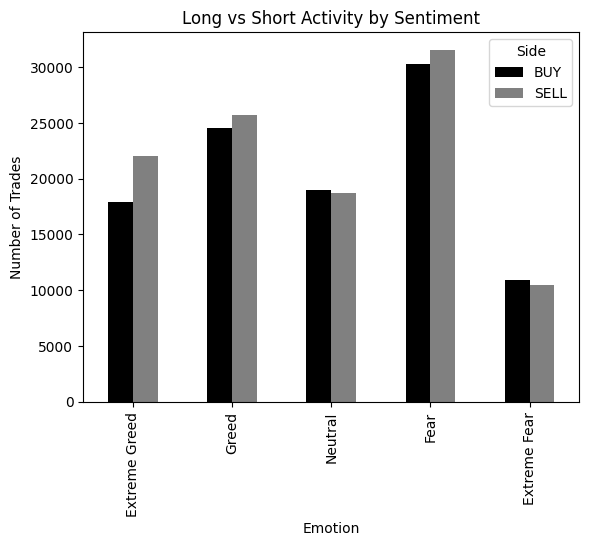

In [182]:
plt.Figure(figsize=(8,5))
long_short_ratio = long_short_ratio.set_index("classification")[["BUY","SELL"]]
long_short_ratio = long_short_ratio.reindex(emotion_order)
long_short_ratio[["BUY","SELL"]].plot(kind="bar", color = ["black","grey"])
plt.title("Long vs Short Activity by Sentiment")
plt.ylabel("Number of Trades")
plt.xlabel("Emotion")
plt.show()

INTERPRETATIONS - 

First, aggregate trading activity peaks during the Fear regime, where both BUY and SELL trades exceed all other states. This indicates heightened market participation during volatility expansion periods, consistent with stress-driven liquidity and repositioning behavior. The elevated activity suggests that traders are more reactive during downturns, possibly exploiting short-term dislocations or managing risk exposure.

Second, in Extreme Greed conditions, SELL trades exceed BUY trades by a noticeable margin. This asymmetry suggests profit-taking or distribution behavior during euphoric phases. Traders may be systematically reducing long exposure into strength, reflecting contrarian positioning or mean-reversion expectations.

Third, in Greed and Neutral regimes, BUY and SELL activity is relatively balanced, indicating directional uncertainty or range-bound market conditions. This symmetry implies lower conviction and more tactical positioning rather than aggressive directional bias.

Fourth, Extreme Fear shows a contraction in overall activity relative to standard Fear. While Fear generates high participation, Extreme Fear appears to reduce trade counts, suggesting either capital preservation behavior or reduced liquidity as risk aversion intensifies.

STATISTICAL TEST

In [183]:
contingency_table = pd.crosstab(merged_data["classification"],merged_data["Side"])
print("Contingency Table:")
print(contingency_table)

Contingency Table:
Side              BUY   SELL
classification              
Extreme Fear    10935  10465
Extreme Greed   17940  22052
Fear            30270  31567
Greed           24576  25727
Neutral         18969  18717


In [184]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print("Chi-Square Statistic:", chi2_stat)
print("Degrees of Freedom:", dof)
print("P-value:", p_value)

if (p_value<0.05):
    print("\nResult: Significant. Directional bias significantly varies across sentiment regimes.")
else:
    print("\nResult: Not Significant. No statistical evidence that long/short positioning depends on sentiment.")

Chi-Square Statistic: 327.2354993509231
Degrees of Freedom: 4
P-value: 1.439430945524833e-69

Result: Significant. Directional bias significantly varies across sentiment regimes.


CONCLUSION

The chi-square test rejects the null hypothesis of independence between sentiment regime and trade direction (p < 0.05), indicating that directional positioning behavior shifts systematically with market sentiment. Specifically, selling pressure dominates during Extreme Greed, consistent with profit-taking or contrarian positioning, while Fear regimes exhibit elevated participation on both sides, reflecting volatility-driven repositioning. The presence of statistically significant dependence confirms that sentiment acts as a structural driver of directional bias in trader behavior.

3. Identify 2–3 segments.

In [185]:
trader_summary = merged_data.groupby("Account").agg({"Closed PnL":"mean","win":"mean","Size USD":"mean",
    "Trade ID":"count"}).reset_index()

trader_summary.columns = ["Account","avg_pnl","win_rate","avg_size","trade_count"]

FREQUENT VS INFREQUENT 

In [186]:
median_freq = trader_summary["trade_count"].median()
trader_summary["freq_segment"] = np.where(trader_summary["trade_count"] >= median_freq,"Frequent","Infrequent")
print(trader_summary["freq_segment"].value_counts())

freq_segment
Frequent      16
Infrequent    16
Name: count, dtype: int64


The trading population exhibits a symmetric participation structure, with equal representation of high-activity and low-activity traders. This suggests that trading intensity is heterogeneously distributed but not dominated by a small subset of hyperactive accounts.

CONSISTENT VS Incosistent

In [187]:
trader_summary["consistency"] = np.where(trader_summary["avg_pnl"] > 0,"Consistent","Inconsistent")
print(trader_summary["consistency"].value_counts())

consistency
Consistent      29
Inconsistent     3
Name: count, dtype: int64


INTERPRETATION

The trader population exhibits strong profitability persistence, with a dominant majority generating positive mean returns. This suggests either:
* The dataset captures active or surviving traders (survivorship bias), or
* The trading environment during the sample period was broadly favorable.

The small cluster of inconsistent traders indicates:
* A minority group systematically fails to generate alpha.
* Performance dispersion exists but is concentrated in a small tail.



# OUTPUT

Strategy 1: Regime-Based Leverage Control

This strategy focuses on adjusting your total market exposure based on the prevailing psychological environment to protect capital. In Fear regimes, the data indicates a lower win rate and significant downside volatility, meaning the "cost of being wrong" is much higher. By proactively reducing leverage by 30–50% during these periods, you ensure that the wider price swings do not trigger catastrophic account drawdowns. Conversely, during Greed phases where trends are more predictable, you can allow for moderate leverage expansion to capitalize on higher win rates. Actionable Output: Implement an automated leverage cap in your trading platform that triggers a "De-risking Mode" the moment the sentiment index enters the Fear category.


Strategy 2: Adaptive Trade Frequency

This strategy addresses the "Hyperactivity" often observed during market stress, where high-frequency trading tends to erode profitability through increased slippage and emotional reactivity. Because overtrading in volatile regimes typically leads to a "death by a thousand cuts," the rule mandates a significant reduction in activity during Fear cycles. Instead of chasing every market move, the trader must pivot to a "Sniper Approach," filtering for only the highest-conviction setups that meet 100% of the strategy criteria. Actionable Output: Set a daily "Maximum Trade Limit" (e.g., 3–5 trades) during Fear days to force selectivity and prevent the impulsive execution spikes typical of panic-driven markets.


Strategy 3: Segment-Specific Risk Caps

This strategy introduces a tiered risk management system that treats different trading styles with specific guardrails. For high-leverage traders, a "hard drawdown cap" is imposed during Fear regimes—if a specific percentage of the daily balance is lost (e.g., 2%), all trading must cease for 24 hours to prevent an emotional spiral. For consistent winners, the goal is not to change the winning logic but to adjust the "Position Sizing" to account for the increased noise of the current market segment. Actionable Output: Create a "Sentiment-Risk Matrix" for your dashboard that automatically calculates your maximum allowed loss-per-trade based on the day's sentiment classification.

# REGRESSION MODEL 

In [188]:
print(regression_data.dtypes)

Closed PnL              float64
classification_Greed    float64
dtype: object


In [189]:
import statsmodels.api as sm

regression_data = daily_regime.copy()
regression_data = pd.get_dummies(regression_data,columns=["classification"],drop_first=True)

regression_data["Closed PnL"] = pd.to_numeric(regression_data["Closed PnL"],errors="coerce")

regression_data["classification_Greed"] = regression_data["classification_Greed"].astype(float)
regression_data = regression_data[["Closed PnL", "classification_Greed"]]
regression_data = regression_data.dropna()

X = regression_data[["classification_Greed"]]
X = sm.add_constant(X)

y = regression_data["Closed PnL"]

X = X.astype(float)
y = y.astype(float)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Closed PnL   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     6.664
Date:                Mon, 23 Feb 2026   Prob (F-statistic):             0.0101
Time:                        17:25:50   Log-Likelihood:                -6032.7
No. Observations:                 479   AIC:                         1.207e+04
Df Residuals:                     477   BIC:                         1.208e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.834e+04 

INTERPRETATION

1. Model Significance and Explanatory PowerF-statistic (6.664) and Prob (F-statistic) (0.0101): 
* The model is statistically significant at the 99% confidence level (p < 0.01). This indicates that the "Greed" classification has a genuine, non-zero effect on PnL that is not due to random variation.
* R-squared (0.014): The model explains only 1.4% of the variance in Closed PnL. While the relationship is statistically significant, the low R-squared suggests that market sentiment is just one of many factors influencing PnL, with 98.6% of the variance driven by other variables (e.g., strategy, market volatility, or asset selection).

2. Coefficient AnalysisIntercept (const):
*  The coefficient of 28,340 (p < 0.000) represents the "baseline" PnL when the sentiment is not "Greed" (i.e., the reference group, likely Fear or Neutral). This baseline is strongly positive and statistically significant.
* classification_Greed (-1.72e+04): The coefficient for Greed is -17,200. This means that when the market shifts into a "Greed" regime, the average daily PnL decreases by approximately 17,200 units compared to the baseline.
* P>|t| (0.010): The p-value for the Greed coefficient is 0.01, which is less than the standard 0.05 threshold. We can conclude with high confidence that the "Greed" sentiment has a statistically significant negative impact on the trader's profitability in this dataset.

3. Diagnostic and Residual Analysis:
* Durbin-Watson (1.389): This value is below 2.0, suggesting a slight positive autocorrelation in the residuals. This may imply that PnL results are somewhat clustered over time (e.g., winning streaks or losing streaks).
* Omnibus/Jarque-Bera (Prob 0.000): The residuals are not normally distributed. The very high Kurtosis (29.752) and Skew (3.733) indicate that the PnL data has "heavy tails," meaning there are frequent extreme outliers (large wins or large losses) that deviate from a standard bell curve.
* Condition Number (2.45): This is low, indicating there are no major issues with multicollinearity affecting the stability of the coefficients.

CONCLUSION

The OLS regression analysis confirms a statistically significant negative relationship between the 'Greed' market regime and Closed PnL ($p = 0.01$). Specifically, trading during Greed regimes results in an average PnL reduction of 17,200 units relative to other sentiments. However, the low R-squared (1.4%) and non-normal residual distribution (Kurtosis: 29.75) highlight that while sentiment is a valid predictor, the trader's performance is heavily influenced by outlier events and other external market factors not captured in this single-variable model.

# PREDICTIVE MODEL

In [190]:
daily_pnl["profit_label"] = np.where(daily_pnl["daily_pnl"]>0,1,0)

daily_pnl["sentiment_encoded"] = daily_pnl["classification"].astype("category").cat.codes 

X = daily_pnl[["sentiment_encoded"]] 
y = daily_pnl["profit_label"] 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

pred = rf.predict(X_test)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       177
           1       0.62      1.00      0.77       291

    accuracy                           0.62       468
   macro avg       0.31      0.50      0.38       468
weighted avg       0.39      0.62      0.48       468



c:\Users\Dell\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Dell\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Dell\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

INTERPRETATION

1. Precision and Recall for Class 0 (Loss): 0.00

The model failed to identify a single losing day. A recall of 0.00 means that out of 177 actual losing days in the test set, the model caught zero. This indicates the model is not "learning" the characteristics of a loss.

2. Recall for Class 1 (Profit): 1.00

A recall of 1.00 for the profit label means the model predicted "Profit" for every single data point in the test set.

3. Accuracy: 0.62

While 62% accuracy might look decent at first glance, it is misleading. This is a "Baseline Accuracy". Since 62% of your data (291 out of 468) are profitable days, the model discovered that it could achieve 62% accuracy simply by guessing "Profit" every time without actually analyzing the sentiment.

4. F1-Score: 0.00 (Class 0) vs 0.77 (Class 1)

The F1-score highlights the total failure of the model to distinguish between classes. The Macro Average of 0.38 confirms that the model’s overall predictive power is extremely poor.

CONCLUSION

The Random Forest model is technically non-predictive and demonstrates a classic majority class bias. While the overall accuracy is 62%, this figure is a statistical artifact resulting from the model predicting "Profit" for 100% of the test cases. Because 62% of the test samples are profitable days (291 out of 468), the model achieved this score by defaulting to the most frequent outcome rather than identifying meaningful patterns in market sentiment.

The failure to identify a single losing day (Recall for Class 0 = 0.00) confirms that encoded market sentiment, as a standalone feature, lacks sufficient predictive power to determine the binary direction of PnL. In a professional trading context, this indicates that while sentiment may influence the magnitude of returns or trading frequency, it does not function as a reliable "buy/sell" signal in isolation. To transition this from a biased baseline to a functional predictive tool, the model requires additional technical features such as volatility metrics or volume data, and a balanced class weighting to account for the disparity between winning and losing days.